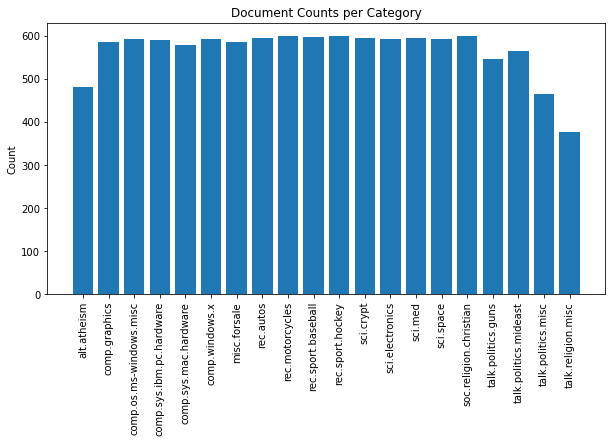

In [1]:
#Q1
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

plt.rcParams['figure.figsize'] = [10,5]

twenty_plot = fetch_20newsgroups(subset='train')
labels = twenty_plot.target_names

y = list(range(20))
for i in range(20):
    y[i] = np.count_nonzero(twenty_plot.target == i)

plt.bar(labels,y)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Document Counts per Category")
plt.show()

In [2]:
#Q2
#Questions for TA:
#random_state for dataset fetch? None or 42? 42 used in discussion but project doc says None

import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.corpus import stopwords

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

lemur = nltk.wordnet.WordNetLemmatizer()

#Vectorizer
analyzer = CountVectorizer().build_analyzer()
tfidf_transformer = TfidfTransformer()

#Download dataset
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42) #should 42 be None?
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

combined_stopwords = set.union(set(stopwords.words('english')),set(punctuation))

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    return [lemur.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(text)]

#Updated analyzer to avoid counting digits and punctuation
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc, stop_words='english')

corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

#X_train_counts = count_vect.fit_transform(corpus)

X_train_counts = count_vect.fit_transform(train_dataset.data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test_dataset.data)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("X_train shape: ", X_train_tfidf.shape)
print("X_test shape: ", X_test_tfidf.shape)



X_train shape:  (4732, 16466)
X_test shape:  (3150, 16466)


In [3]:
#Q3
#Questions for TA:
#random_state for nmf and trunc svd? 0 or 42? 

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.utils.extmath import randomized_svd

trunc_svd = TruncatedSVD(n_components=50, random_state=0)
X_train_lsi = trunc_svd.fit_transform(X_train_tfidf)
X_test_lsi = trunc_svd.transform(X_test_tfidf)

#Get trunc svd matrices
#https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
U, Sigma, VT = randomized_svd(X_train_tfidf, n_components=50, random_state=0)
Sigma = np.diag(Sigma) #Make sigma values a diag matrix rather than nx1

nmf_model = NMF(n_components=50, init='random', random_state=0)
X_train_nmf = nmf_model.fit_transform(X_train_tfidf)
X_test_nmf = nmf_model.transform(X_test_tfidf)
H = nmf_model.components_
error_lsi = np.sum(np.array(X_train_tfidf - U.dot(Sigma.dot(VT)))**2)
error_nmf = np.sum(np.array(X_train_tfidf - X_train_nmf.dot(H))**2)

print('LSI Train error: ', error_lsi)
print('NMF Train error: ', error_nmf)

print('LSI Train shape: ', X_train_lsi.shape)
print('LSI Test shape: ', X_test_lsi.shape)
print('NMF Train shape: ', X_train_nmf.shape)
print('NMF Test shape: ', X_test_nmf.shape)

LSI Train error:  4099.651344825857
NMF Train error:  4143.541730848815
LSI Train shape:  (4732, 50)
LSI Test shape:  (3150, 50)
NMF Train shape:  (4732, 50)
NMF Test shape:  (3150, 50)


Soft margin prediction stats:
              precision    recall  f1-score   support

           0     1.0000    0.3372    0.5043      1560
           1     0.6059    1.0000    0.7546      1590

    accuracy                         0.6717      3150
   macro avg     0.8030    0.6686    0.6295      3150
weighted avg     0.8011    0.6717    0.6307      3150

Hard margin prediction stats:
              precision    recall  f1-score   support

           0     0.9799    0.9686    0.9742      1560
           1     0.9695    0.9805    0.9750      1590

    accuracy                         0.9746      3150
   macro avg     0.9747    0.9745    0.9746      3150
weighted avg     0.9747    0.9746    0.9746      3150

Optimal prediction stats:
              precision    recall  f1-score   support

           0     0.9799    0.9686    0.9742      1560
           1     0.9695    0.9805    0.9750      1590

    accuracy                         0.9746      3150
   macro avg     0.9747    0.9745    0.974

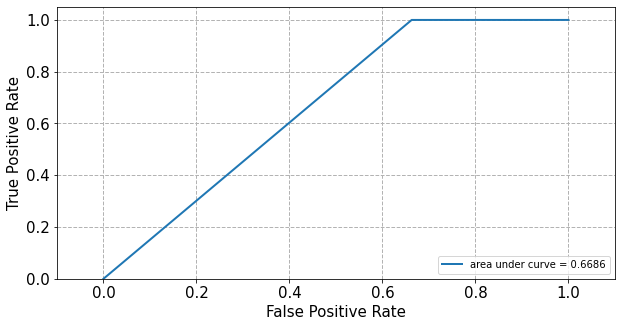

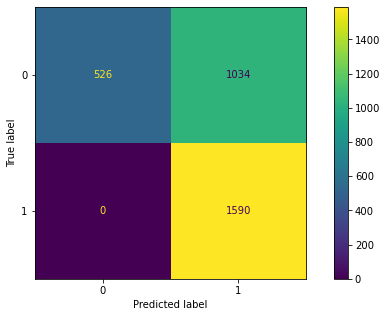

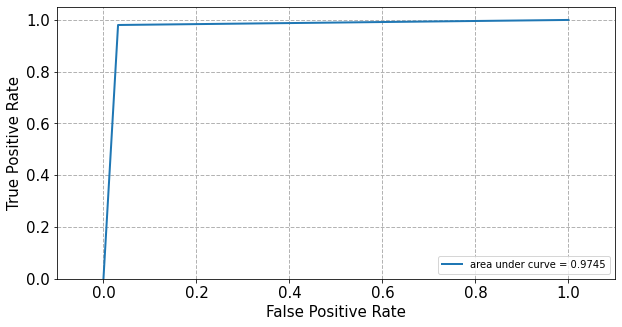

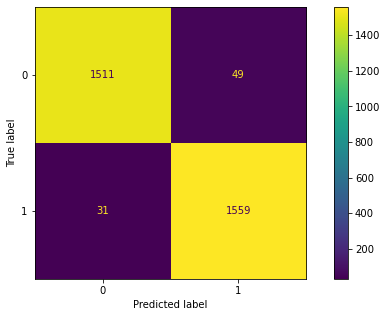

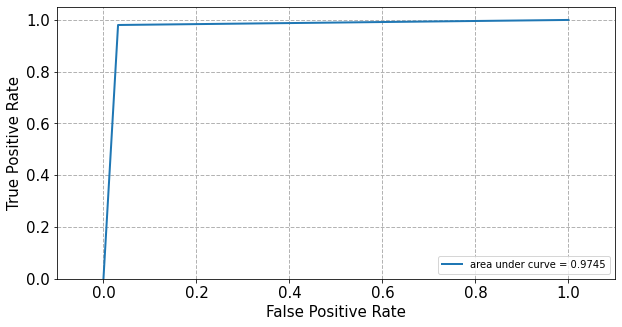

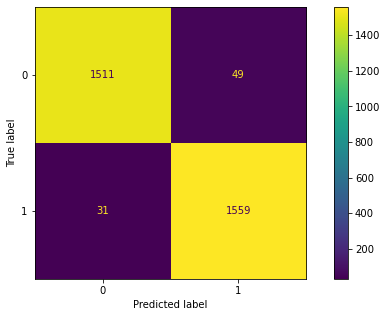

In [9]:
#Q4
from sklearn.svm import LinearSVC
from sklearn import metrics

#Start by changing to binary classification
train_targets_bin = train_dataset.target.copy()
for i in range(len(train_targets_bin)):
    if train_dataset.target[i] in [0,1,2,3]:
        train_targets_bin[i] = 0
    else:
        train_targets_bin[i] = 1
        
test_targets_bin = test_dataset.target.copy()
for i in range(len(test_targets_bin)):
    if test_dataset.target[i] in [0,1,2,3]:
        test_targets_bin[i] = 0
    else:
        test_targets_bin[i] = 1

#Train hard and soft margin SVCs - using LSI data per instructions - then get stats
soft_margin_SVC = LinearSVC(C=0.0001,max_iter=90000).fit(X_train_lsi, train_targets_bin)
soft_margin_prediction = soft_margin_SVC.predict(X_test_lsi)

hard_margin_SVC = LinearSVC(C=1000,max_iter=90000).fit(X_train_lsi, train_targets_bin)
hard_margin_prediction = hard_margin_SVC.predict(X_test_lsi)

fpr_soft, tpr_soft, thresholds_soft = metrics.roc_curve(test_targets_bin, soft_margin_prediction, pos_label=1)
fpr_hard, tpr_hard, thresholds_hard = metrics.roc_curve(test_targets_bin, hard_margin_prediction, pos_label=1)

#I stole this helper function from the discussion notebook!
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
        
#Show the stats for our model (part 1 of question)       
plot_roc(fpr_soft,tpr_soft)
metrics.plot_confusion_matrix(soft_margin_SVC, X_test_lsi, test_targets_bin)
print("Soft margin prediction stats:")
print(metrics.classification_report(test_targets_bin,soft_margin_prediction,digits=4))

plot_roc(fpr_hard,tpr_hard)
metrics.plot_confusion_matrix(hard_margin_SVC, X_test_lsi, test_targets_bin)
print("Hard margin prediction stats:")
print(metrics.classification_report(test_targets_bin,hard_margin_prediction,digits=4))

#hard margin is much better than soft!

#Part 2!
def find_best_gamma(ks):
    best_k = -100
    best_acc = 0
    for i in ks: 
        k_SVC = LinearSVC(C=10**i,max_iter=90000).fit(X_train_lsi, train_targets_bin)
        k_prediction = k_SVC.predict(X_test_lsi)
        scores = metrics.confusion_matrix(test_targets_bin,k_prediction)
        acc = (scores[0][0]+ scores[1][1])/(scores[0][0]+ scores[0][1] + scores[1][0]+ scores[1][1])
        if acc > best_acc:
            best_k = i
            best_acc = acc
    return best_k
        
        
k = find_best_gamma([-3,-2,-1,0,1,2,3])

#recalculate model w/best k and report stats
optimal_SVC = LinearSVC(C=10**k,max_iter=50000).fit(X_train_lsi, train_targets_bin)
optimal_prediction = optimal_SVC.predict(X_test_lsi)
fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(test_targets_bin, optimal_prediction, pos_label=1)
plot_roc(fpr_opt,tpr_opt)
metrics.plot_confusion_matrix(optimal_SVC, X_test_lsi, test_targets_bin)
print("Optimal prediction stats:")
print(metrics.classification_report(test_targets_bin,optimal_prediction,digits=4))



Non-regularized logistic classifier stats:
              precision    recall  f1-score   support

           0     0.9811    0.9647    0.9729      1560
           1     0.9660    0.9818    0.9738      1590

    accuracy                         0.9733      3150
   macro avg     0.9735    0.9733    0.9733      3150
weighted avg     0.9735    0.9733    0.9733      3150

L1 logistic classifier stats with C = 1
              precision    recall  f1-score   support

           0     0.9811    0.9647    0.9729      1560
           1     0.9660    0.9818    0.9738      1590

    accuracy                         0.9733      3150
   macro avg     0.9735    0.9733    0.9733      3150
weighted avg     0.9735    0.9733    0.9733      3150

L2 logistic classifier stats with C = 3
              precision    recall  f1-score   support

           0     0.9817    0.9654    0.9735      1560
           1     0.9666    0.9824    0.9744      1590

    accuracy                         0.9740      3150
   ma

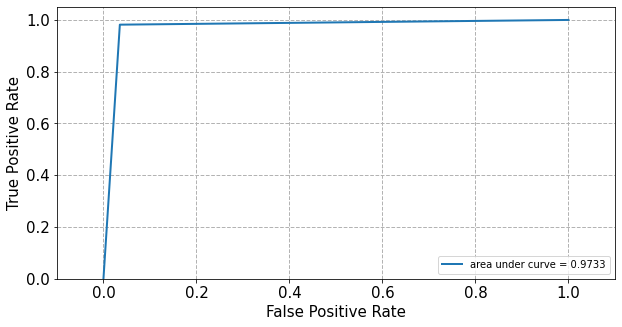

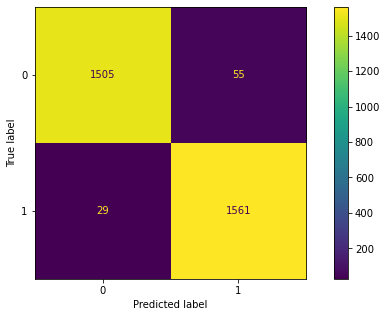

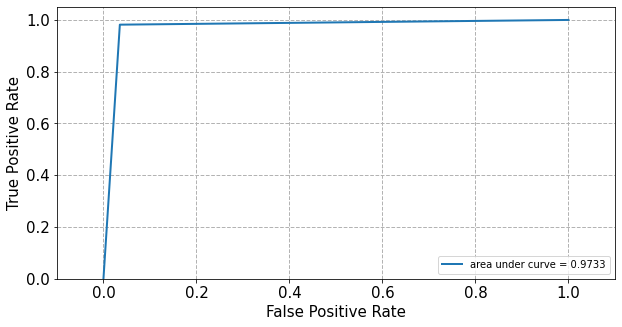

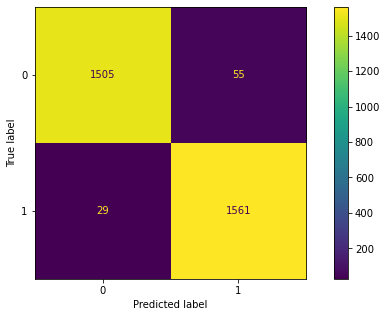

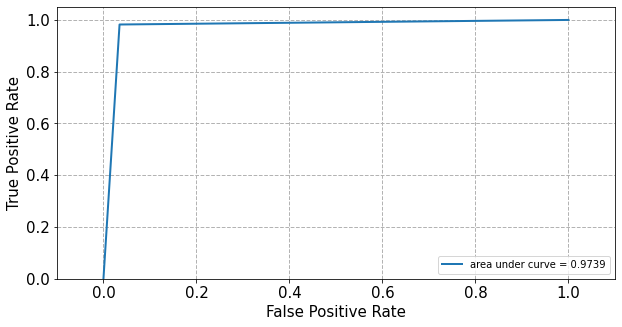

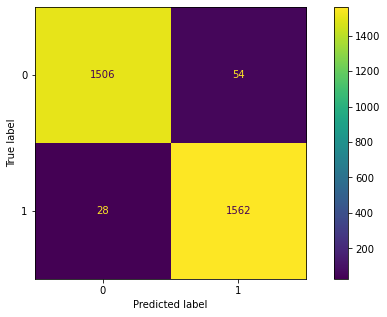

In [11]:
#Q5 
from sklearn.linear_model import LogisticRegression
#Part 1
#C is "Inverse of regularization strength", so a really big value approximates no regularization
log_class_no_reg = LogisticRegression(C=9999999999,solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_no_reg_prediction = log_class_no_reg.predict(X_test_lsi)

fpr, tpr, threshold = metrics.roc_curve(test_targets_bin, log_class_no_reg_prediction, pos_label=1)

plot_roc(fpr,tpr)
metrics.plot_confusion_matrix(log_class_no_reg, X_test_lsi, test_targets_bin)
print("Non-regularized logistic classifier stats:")
print(metrics.classification_report(test_targets_bin,log_class_no_reg_prediction,digits=4))

#Part 2a - finding best regularization parameter
def find_best_reg(ks, reg_type):
    best_k = -100
    best_acc = 0
    for i in ks: 
        k_LR = LogisticRegression(C=10**i, penalty=reg_type,solver='liblinear').fit(X_train_lsi, train_targets_bin)
        k_prediction = k_LR.predict(X_test_lsi)
        scores = metrics.confusion_matrix(test_targets_bin,k_prediction)
        acc = (scores[0][0]+ scores[1][1])/(scores[0][0]+ scores[0][1] + scores[1][0]+ scores[1][1])
        if acc > best_acc:
            best_k = i
            best_acc = acc
    return best_k

k_l1 = find_best_reg([-3,-2,-1,0,1,2,3], "l1")
k_l2 = find_best_reg([-3,-2,-1,0,1,2,3], "l2")

#part 2b: getting stats for optimal l1 and l2 reg parameters (no-reg done in part 1)

#l1 case
log_class_l1 = LogisticRegression(C=10**k_l1, penalty="l1",solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_l1_prediction = log_class_l1.predict(X_test_lsi)

fpr_l1, tpr_l1, threshold_l1 = metrics.roc_curve(test_targets_bin, log_class_l1_prediction, pos_label=1)

plot_roc(fpr_l1,tpr_l1)
metrics.plot_confusion_matrix(log_class_l1, X_test_lsi, test_targets_bin)
print("L1 logistic classifier stats with C = " + str(k_l1))
print(metrics.classification_report(test_targets_bin,log_class_l1_prediction,digits=4))

#l2 case
log_class_l2 = LogisticRegression(C=10**k_l2, penalty="l2",solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_l2_prediction = log_class_l2.predict(X_test_lsi)

fpr_l2, tpr_l2, threshold_l2 = metrics.roc_curve(test_targets_bin, log_class_l2_prediction, pos_label=1)

plot_roc(fpr_l2,tpr_l2)
metrics.plot_confusion_matrix(log_class_l2, X_test_lsi, test_targets_bin)
print("L2 logistic classifier stats with C = " + str(k_l2))
print(metrics.classification_report(test_targets_bin,log_class_l2_prediction,digits=4))



Naive Bayes classification stats:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1560
           1       0.86      0.97      0.91      1590

    accuracy                           0.91      3150
   macro avg       0.92      0.91      0.91      3150
weighted avg       0.92      0.91      0.91      3150



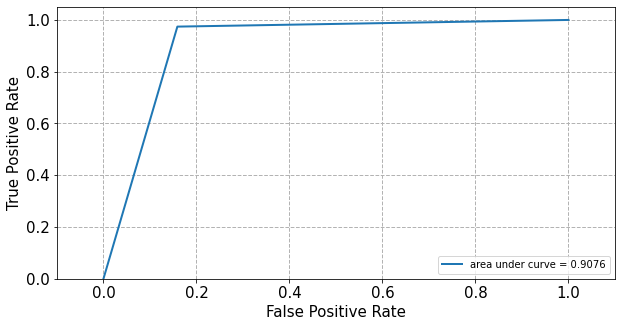

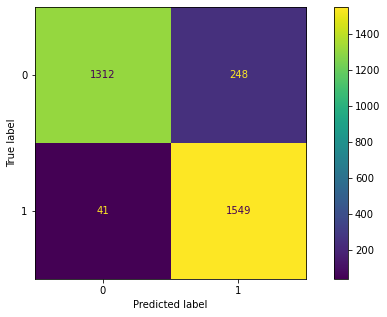

In [12]:
#Q6
from sklearn.naive_bayes import GaussianNB

gauss_NB = GaussianNB().fit(X_train_lsi, train_targets_bin)
gauss_NB_prediction = gauss_NB.predict(X_test_lsi)

fpr_NB, tpr_NB, threshold_NB = metrics.roc_curve(test_targets_bin, gauss_NB_prediction, pos_label=1)

plot_roc(fpr_NB,tpr_NB)
metrics.plot_confusion_matrix(gauss_NB, X_test_lsi, test_targets_bin)
print("Naive Bayes classification stats:")
print(metrics.classification_report(test_targets_bin,gauss_NB_prediction))

In [65]:
#Q7
#Can we do two grid searches, one for each set of data, then pick the best of the two for our best parameters?
#Are we allowed to remove headers/footers when loading in the data? Instead of using the code given to us
#What is test score rank? From table or from evaluating on the test set? For the former, do we take the best performance between the two datasets?
# How will it be graded? What if my best combination is different that your default one?

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
import pandas as pd

import joblib

def stem_rmv_punc_nolem(doc):
    return (word for word in analyzer(doc) if word not in combined_stopwords and not word.isdigit())

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

#Get train and test set with no headers/footers, and turn classification to binary
train_dataset_nohf = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42, remove=('headers','footers'))
test_dataset_nohf = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42, remove=('headers','footers'))

train_targets_nohf_bin = train_dataset_nohf.target.copy()
for i in range(len(train_targets_nohf_bin)):
    if train_dataset_nohf.target[i] in [0,1,2,3]:
        train_targets_nohf_bin[i] = 0
    else:
        train_targets_nohf_bin[i] = 1
        
test_targets_nohf_bin = test_dataset_nohf.target.copy()
for i in range(len(test_targets_nohf_bin)):
    if test_dataset_nohf.target[i] in [0,1,2,3]:
        test_targets_nohf_bin[i] = 0
    else:
        test_targets_nohf_bin[i] = 1

#init pipeline       
cachedir = mkdtemp()
memory = joblib.Memory(cachedir=cachedir, verbose=10)
pipeline = Pipeline([
    ('vect', None),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', None),
    ('clf', None),
],
memory=memory
)

#define pipeline params
param_grid = [
    {
        'vect': [CountVectorizer(analyzer=stem_rmv_punc, stop_words='english'), CountVectorizer(analyzer=stem_rmv_punc_nolem, stop_words='english')],
        'reduce_dim': [NMF(n_components=50, init='random', random_state=0), TruncatedSVD(n_components=50, random_state=0)],
        'clf': [LogisticRegression(C=1000, penalty="l2", solver='liblinear'), LogisticRegression(C=10, penalty="l1", solver='liblinear'), LinearSVC(C=100),  GaussianNB()],
        'vect__min_df':[3,5],
    },
]

models_in = {
    'Pipeline': pipeline
}

params_in = {
    'Pipeline': param_grid
}

#Run grid search
#grid_search = EstimatorSelectionHelper(models_in, params_in)
#grid_search.fit(train_dataset.data, train_targets_bin, n_jobs=1, cv=5, scoring='accuracy')
#grid_search.score_summary(sort_by='max_score')


#grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
#grid.fit(train_dataset.data, train_targets_bin)
#print(pd.DataFrame(grid.cv_results_))
rmtree(cachedir)

<ipython-input-65-c09da2f52584>:93: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\loicm\\AppData\\Local\\Temp\\tmp7d52rbcp'", use "location='C:\\Users\\loicm\\AppData\\Local\\Temp\\tmp7d52rbcp'" instead.
  memory = joblib.Memory(cachedir=cachedir, verbose=10)


In [24]:
grid_search.fit(train_dataset_nohf.data, train_targets_nohf_bin, n_jobs=1, cv=5, scoring='accuracy')
grid_search.score_summary(sort_by='max_score')

Running GridSearchCV for Pipeline.
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000015A4C0EEB80>,
                min_df=3, stop_words='english'), 
[ 'Hank Greenberg was probably the greatest ever.  He was also subject to a\n'
  'lot of heckling from bigots on the opposing teams and in the stands, but\n'
  'it never seemed to affect his performance negatively.',
  'On March 21, 1993 Roger Maynard wrote (in reply to an article by Graham\n'
  'Hudson):\n'
  '\n'
  '>> will still have the Jennings Trophy at the end of the year.  Potvin is '
  'very\n'
  '>> good, and I do believe that he will be a star, but I want to see him\n'
  '>> perform in the playoffs under pressure.\n'
  '\n'
  '>You don\'t think he is performing "under pressure" now?  The major\n'
  '>differences  between playoff hockey and normal hockey is 1. play-\n'
  '>ing ever..., 
array([1, ..., 

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 18.5s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000015A4C0EEB80>,
                min_df=3, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> 

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 21.4s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000015A4C0EEB80>,
                min_df=3, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> 

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 14.2s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000015A4C0EEB80>,
                min_df=5, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> 

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


________________________________________________fit_transform_one - 9.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000015A4C0EEB80>,
                min_df=5, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> 

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 19.6s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000015A4C0EEB80>,
                min_df=5, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> 

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\pipeline.py:292: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


_______________________________________________fit_transform_one - 56.4s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <3786x7434 sparse matrix of type '<class 'numpy.int64'>'
	with 225907 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=0), <3786x7434 sparse matrix of type '<class 'numpy.float64'>'
	with 225907 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 20.5s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000015A4C0EEB80>,
                min_df=5, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> 

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\pipeline.py:292: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


_______________________________________________fit_transform_one - 68.8s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <3786x7484 sparse matrix of type '<class 'numpy.int64'>'
	with 226562 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1], dtype=int64), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=0), <3786x7484 sparse matrix of type '<class 'numpy.float64'>'
	with 226562 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1], dtype=int64), None, message_clsname='Pipeline', message=None)
_______________________________________________

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\pipeline.py:292: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <3785x13898 sparse matrix of type '<class 'numpy.int64'>'
	with 250563 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=0), <3785x13898 sparse matrix of type '<class 'numpy.float64'>'
	with 250563 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 30.9s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc_nolem at 0x0000015A5C762280>,
                min_df=3, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\pipeline.py:292: UserWarning: Persisting input arguments took 0.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <3786x14034 sparse matrix of type '<class 'numpy.int64'>'
	with 250231 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=0), <3786x14034 sparse matrix of type '<class 'numpy.float64'>'
	with 250231 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)
_____________________________________________

C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 30.1s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc_nolem at 0x0000015A5C762280>,
                min_df=3, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\pipeline.py:292: UserWarning: Persisting input arguments took 0.66s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <3785x8719 sparse matrix of type '<class 'numpy.int64'>'
	with 233103 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=0), <3785x8719 sparse matrix of type '<class 'numpy.float64'>'
	with 233103 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 21.9s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc_nolem at 0x0000015A5C762280>,
                min_df=5, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 17.7s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc_nolem at 0x0000015A5C762280>,
                min_df=5, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 17.2s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc_nolem at 0x0000015A5C762280>,
                min_df=5, stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


_______________________________________________fit_transform_one - 16.9s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\640b35fd4272fbab36af3f6ecbd94be0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d2b89a0babdda38f634374a12b40c845
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=0), <3785x11876 sparse matrix of type '<class 'numpy.float64'>'
	with 241634 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', mes

________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\cc495905e59b0cc2d953d16a56db7cfe
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\46d3b4235f0a880b73f60747b896f740
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=0), <3786x7484 sparse matrix of type '<class 'numpy.float64'>'
	with 226562 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1], dtype=int64), None, message_clsname='Pipeline', mess

[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\1610ce415cd7f8fa4d555260b8bd6a42
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50, random_state=0), <3786x8730 sparse matrix of type '<class 'numpy.float64'>'
	with 232352 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0], dtype=int64), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.2s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a17936d01742ab0b4a0d227bca5d5a4e
___________________________________fit_transform_one cache loaded - 0.1

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\01b9e1e6e10b49aa4c24d4c8ff71eb16
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\944e0c4976935b457ce327292dbde93e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e9840988e68123bb612113ad05cf3e89
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\8d66683a20469c1eae195e93db68654e
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a17936d01742ab0b4a0d227bca5d5a4e
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\6f91c145a2cf413416da774234d169aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\5ee02a0fc9eb2db32006fb99e8ddd739
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0022bf4005e861d42d366e606e37f66a
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\cc495905e59b0cc2d953d16a56db7cfe
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\46d3b4235f0a880b73f60747b896f740
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\fbbd0e5fd4dbbb525a15867be5cccc13
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\03b0fca1f04128cc03f8fd46b70c032d
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\640b35fd4272fbab36af3f6ecbd94be0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d2b89a0babdda38f634374a12b40c845
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\305db683ccdac12c54b5f0a97556d81d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\35c55b41e6a5ec76c28c314dabe2ec84
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\b1cd4dd8cd50df40c1b9baf346ded6c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\7c38d5d02529581850b2baff4fc5bb12
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\436c78a6a084d22b80b7049f15743520
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0a382668dc9012b34aa1d6c30988d002
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0de48a7ecb29dc99cc6e7b0e65fc0bd5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\65ef5eaeef4e54f9472d80626bd068c1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\c3f51be312ed2d1dbd7eff6250912c6d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\b60735eaa5e222b5e2ca54e54e2a921b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\bcbb7bb0b6ce9b178904bb8cf81cef6a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\1391401e6912a3b5ff2e647ecf1d01b9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a3e9b144a42c29c896d95d3e1ba4cb63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\ed67ea5aa9724632541676d82cd333a2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\ea4d367b2b84c3bc93db17d54c7c4f76
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\552ded3dccb89601e76a4ade7647f5fa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a77ca448e6bebecdd0b26dacf49acdb4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\7db82a8887f5804cffc839305a1ea241
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\3c003b43e5885489ed3c93cfd3e90944
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\01b9e1e6e10b49aa4c24d4c8ff71eb16
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\944e0c4976935b457ce327292dbde93e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e9840988e68123bb612113ad05cf3e89
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\8d66683a20469c1eae195e93db68654e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\90696aaef1373c0c26e6d440a37bbca5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\fb191c382928d2c4ed621dc1b3f78506
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\cc495905e59b0cc2d953d16a56db7cfe
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\46d3b4235f0a880b73f60747b896f740
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\9230e75663c2b5fed18a982280923127
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\03b0fca1f04128cc03f8fd46b70c032d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\c8d38fc18c12ae6d13ca8e8576d5bbd3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\f7aadfc3fdb798fc63d7d6432796f27b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\6ea2bc859f08d70d00b0acba5dab7a3f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d54e12fe620cc787b8b361f32860f205
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\875c4e6f3a7c942eaafb7d5542653807
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\cc5a544bb49fd605ad56eb7a2cc469c3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\49b6fa1f77647a228bd96b0a9737cbbc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e1d9ee9c10482691b38c56299a99a662
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\21966bca10b0f8ae1f0015c11fb15779
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e56179925f788fd4894239b5f2277374
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0304a7d96e1e5ebf7f87b7d13a5ead86
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e47c513568538bf191350b9be8574d1f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\ea0e489da27f808ba7349c2defe082d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0fb17c2292cb228b1b8f62cf68c039b3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a4632c8572000aed8b56f04e501fcfd3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\b2002b19a8def83aa64edee596669f9d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\8e582cebad1d9022ac875fea38d41bf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d2ab6d19d2383758456fb641ac73ac17
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\050a28f06a0fe95c22f3b12aecdc9687
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\09bd589f05899e652b3a05d47cd07556
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e856a2fe059835b657762d47f3580706
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\1610ce415cd7f8fa4d555260b8bd6a42
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\aca16a6ae1becceec44e88c6df7e0e07
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a17936d01742ab0b4a0d227bca5d5a4e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\6f91c145a2cf413416da774234d169aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\5ee02a0fc9eb2db32006fb99e8ddd739
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0022bf4005e861d42d366e606e37f66a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\90e1eaf4c3ed4cfdf21d6096d609fb9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\6792a93e619f34735f0a5ba7974217eb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\640b35fd4272fbab36af3f6ecbd94be0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d2b89a0babdda38f634374a12b40c845
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\00b41ab7ab58ed25fefbe0c948495f1e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\35c55b41e6a5ec76c28c314dabe2ec84
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\b1cd4dd8cd50df40c1b9baf346ded6c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\1ccd0e8a9d413372c48a292a87435771
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\436c78a6a084d22b80b7049f15743520
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0a382668dc9012b34aa1d6c30988d002
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\969fcc6249e2a3cc813ba55f6013f27e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\65ef5eaeef4e54f9472d80626bd068c1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\c3f51be312ed2d1dbd7eff6250912c6d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\09509cbe256a6a75e4449a0ce2bf17a8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\bcbb7bb0b6ce9b178904bb8cf81cef6a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\1391401e6912a3b5ff2e647ecf1d01b9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\5995017b89f37dbe1ab3fb24974f88e9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\ed67ea5aa9724632541676d82cd333a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\ea4d367b2b84c3bc93db17d54c7c4f76
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\201da14c0810a9adeed26ad237075f84
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a77ca448e6bebecdd0b26dacf49acdb4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\7db82a8887f5804cffc839305a1ea241
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\424a4cd6210068080ab6bd5fb24a192d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\01b9e1e6e10b49aa4c24d4c8ff71eb16
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\944e0c4976935b457ce327292dbde93e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\b9668ffa97a55ca5ec41995c015551c4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\8d66683a20469c1eae195e93db68654e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\90696aaef1373c0c26e6d440a37bbca5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0d3124df3426d08fe5380c8792d40847
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\cc495905e59b0cc2d953d16a56db7cfe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\46d3b4235f0a880b73f60747b896f740
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\fbbd0e5fd4dbbb525a15867be5cccc13
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\03b0fca1f04128cc03f8fd46b70c032d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\c8d38fc18c12ae6d13ca8e8576d5bbd3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\7d5fa30afbd275a253003c0121e25abc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\6ea2bc859f08d70d00b0acba5dab7a3f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d54e12fe620cc787b8b361f32860f205
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\3dd74d9fa6915993079bfa944ac11d91
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\cc5a544bb49fd605ad56eb7a2cc469c3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\49b6fa1f77647a228bd96b0a9737cbbc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\3492701e393baba40dd73772c157fbef
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\21966bca10b0f8ae1f0015c11fb15779
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e56179925f788fd4894239b5f2277374
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\c5077557c31e2fc59944b37179afb004
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e47c513568538bf191350b9be8574d1f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\ea0e489da27f808ba7349c2defe082d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\5beb530b5d13c06d330882a02a3ffcd5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a4632c8572000aed8b56f04e501fcfd3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\b2002b19a8def83aa64edee596669f9d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\5660fa8ce67d346aac89a1cc6c3c8cd5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d2ab6d19d2383758456fb641ac73ac17
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\050a28f06a0fe95c22f3b12aecdc9687
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\031a1a3d2cf05cba266c430abdfc1727
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e856a2fe059835b657762d47f3580706
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\1610ce415cd7f8fa4d555260b8bd6a42
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\4ea2ae9b3c544b5ef6c561f882f975fe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\a17936d01742ab0b4a0d227bca5d5a4e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\6f91c145a2cf413416da774234d169aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\2c6eed0c89f3455d98791b39de5f0c1b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0022bf4005e861d42d366e606e37f66a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\90e1eaf4c3ed4cfdf21d6096d609fb9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\fe2a7c2c721d5e89c677e59f546d811f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


C:\Users\loicm\anaconda3\envs\ece219\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\640b35fd4272fbab36af3f6ecbd94be0
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d2b89a0babdda38f634374a12b40c845
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\305db683ccdac12c54b5f0a97556d81d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\35c55b41e6a5ec76c28c314dabe2ec84
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\6ea2bc859f08d70d00b0acba5dab7a3f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\d54e12fe620cc787b8b361f32860f205
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\875c4e6f3a7c942eaafb7d5542653807
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\436c78a6a084d22b80b7049f15743520
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\0a382668dc9012b34aa1d6c30988d002
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\969fcc6249e2a3cc813ba55f6013f27e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\65ef5eaeef4e54f9472d80626bd068c1
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\21966bca10b0f8ae1f0015c11fb15779
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e56179925f788fd4894239b5f2277374
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\c5077557c31e2fc59944b37179afb004
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\loicm\AppData\Local\Temp\tmpcax79qvb\joblib\sklearn\pipeline\_fit_transform_one\e47c513568538bf191350b9be8574d1f
___________________________________fi

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 106.6min finished


Pipeline


In [26]:
grid_search.score_summary(sort_by='max_score')

Pipeline


,estimator,min_score,mean_score,max_score,std_score,clf,reduce_dim,vect,vect__min_df
15,Pipeline,0.965153,0.971259,0.980993,0.005608,"LogisticRegression(C=10, penalty='l1', solver=...","TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,5
7,Pipeline,0.966209,0.971259,0.978881,0.005065,"LogisticRegression(C=1000, solver='liblinear')","TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,5
14,Pipeline,0.968288,0.972104,0.978881,0.004101,"LogisticRegression(C=10, penalty='l1', solver=...","TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,3
6,Pipeline,0.966173,0.971470,0.977825,0.004823,"LogisticRegression(C=1000, solver='liblinear')","TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,3
12,Pipeline,0.965116,0.967877,0.977825,0.004992,"LogisticRegression(C=10, penalty='l1', solver=...","TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,3
23,Pipeline,0.966209,0.970837,0.976769,0.004464,LinearSVC(C=100),"TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,5
22,Pipeline,0.966209,0.971048,0.976769,0.004707,LinearSVC(C=100),"TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,3
21,Pipeline,0.961945,0.965763,0.975713,0.005083,LinearSVC(C=100),"TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,5
13,Pipeline,0.963002,0.967665,0.975713,0.004374,"LogisticRegression(C=10, penalty='l1', solver=...","TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,5
20,Pipeline,0.963002,0.966609,0.974657,0.004161,LinearSVC(C=100),"TruncatedSVD(n_components=50, random_state=0)",CountVectorizer(analyzer=<function stem_rmv_pu...,3


In [71]:
#Q7

#Header/footer included performance using best params
model_l1.fit(X_train_lsi,train_targets_bin)
best_predict = model_l1.predict(X_test_lsi)
print(metrics.classification_report(test_targets_bin,best_predict,digits=4))


#No header/footer performance using best params
X_train_counts_nohf = count_vect.fit_transform(train_dataset_nohf.data)
X_train_tfidf_nohf = tfidf_transformer.fit_transform(X_train_counts_nohf)

X_test_counts_nohf = count_vect.transform(test_dataset_nohf.data)
X_test_tfidf_nohf = tfidf_transformer.transform(X_test_counts_nohf)

X_train_lsi_nohf = trunc_svd.fit_transform(X_train_tfidf_nohf)
X_test_lsi_nohf = trunc_svd.transform(X_test_tfidf_nohf)

model_l1.fit(X_train_lsi_nohf,train_targets_nohf_bin)
best_predict_nohf = model_l1.predict(X_test_lsi_nohf)
print(metrics.classification_report(test_targets_nohf_bin,best_predict_nohf,digits=4))

              precision    recall  f1-score   support

           0     0.9811    0.9647    0.9729      1560
           1     0.9660    0.9818    0.9738      1590

    accuracy                         0.9733      3150
   macro avg     0.9735    0.9733    0.9733      3150
weighted avg     0.9735    0.9733    0.9733      3150

              precision    recall  f1-score   support

           0     0.9784    0.9583    0.9683      1560
           1     0.9599    0.9792    0.9695      1590

    accuracy                         0.9689      3150
   macro avg     0.9692    0.9688    0.9689      3150
weighted avg     0.9691    0.9689    0.9689      3150



In [5]:
#Q9 

embeddings_dict = {}
dimension_of_glove = 300
glove_file = "D:/glove.6B."+ str(dimension_of_glove) + "d.txt"

with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector      



In [6]:
from sklearn.preprocessing import normalize


def glove_preprocess(input_data, input_target):
    first_vect = 0
    doc_num = 0

    #Keep track of which docs have no embeddings so that we remove those indices from the target values
    bad_doc_index_list = []
    
    for doc in input_data:
        found_subj = 0
        found_key = 0
        final_str = ""
        
        #Take subject and keywords lines, and also remove the fwd/re.
        for line in doc.splitlines():
            if (not(found_subj and found_key)):
                if ("Subject:" in line and not found_subj):
                    final_str += " " + line.replace("Subject:", "").replace("Re:","").replace("Fwd:","")
                    found_subj = 1
                elif("subject:" in line and not found_subj):
                    final_str += " " + line.replace("subject:", "").replace("Re:","").replace("Fwd:","")
                    found_subj = 1
                elif("Keywords:" in line and not found_key):
                    final_str += " " + line.replace("Keywords:", "").replace("Re:","").replace("Fwd:","")
                    found_key = 1
                elif("keywords:" in line and not found_key):
                    final_str += " " + line.replace("keywords:", "").replace("Re:","").replace("Fwd:","")
                    found_key = 1
        temp = np.zeros((1,dimension_of_glove))

        count = 0
        
        #Lemmatize each word, then normalize and add to temp
        for elem in stem_rmv_punc(final_str):
            if (elem in embeddings_dict.keys()):
                count += 1
                temp += normalize(embeddings_dict[elem].reshape(-1,1)).T

        #Only add vector to training matrix if embeddings were found
        if (count != 0):
            
            #Take divide by the count to average out the word vectors for the doc
            temp /= count
            if (first_vect == 0):
                glove_data = temp
                first_vect = 1
            else:
                glove_data = np.concatenate((glove_data, temp), axis=0)
        else:
            bad_doc_index_list.append(doc_num)

        doc_num += 1

    
    glove_targets = input_target.copy()
    glove_targets = np.delete(glove_targets, bad_doc_index_list, axis=0)
    return glove_data, glove_targets


In [13]:
glove_train, glove_train_targets = glove_preprocess(train_dataset.data,train_targets_bin)
glove_test, glove_test_targets = glove_preprocess(test_dataset.data,test_targets_bin)

model_l2 = LogisticRegression(C=1000, penalty="l2", solver='liblinear')
model_l1 = LogisticRegression(C=10, penalty="l1", solver='liblinear')
model_svc =  LinearSVC(C=100)
model_gaussian = GaussianNB()

model_l1.fit(glove_train, glove_train_targets)
glove_predict = model_l1.predict(glove_test)
print(metrics.classification_report(glove_test_targets,glove_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9010    0.9103    0.9056      1539
           1     0.9117    0.9025    0.9071      1579

    accuracy                         0.9064      3118
   macro avg     0.9063    0.9064    0.9063      3118
weighted avg     0.9064    0.9064    0.9064      3118



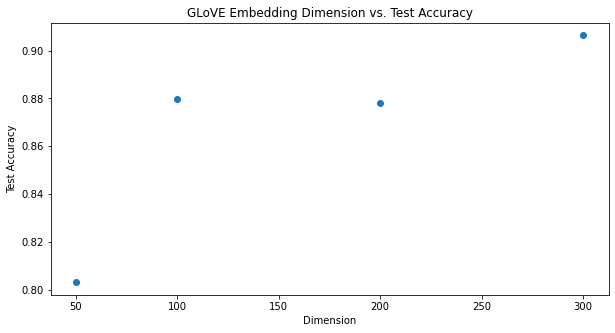

In [70]:
from sklearn.metrics import accuracy_score

test_accuracies = []
dims = [50, 100, 200, 300]
for dim in dims:
    
    embeddings_dict = {}
    dimension_of_glove = dim
    glove_file = "glove.6B."+ str(dimension_of_glove) + "d.txt"

    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector      
    
    glove_train, glove_train_targets = glove_preprocess(train_dataset.data,train_targets_bin)
    glove_test, glove_test_targets = glove_preprocess(test_dataset.data,test_targets_bin)
    model_l1.fit(glove_train, glove_train_targets)
    glove_predict = model_l1.predict(glove_test)
    test_accuracies.append(accuracy_score(glove_test_targets,glove_predict))

plt.figure()
plt.scatter(dims, test_accuracies)
plt.title("GLoVE Embedding Dimension vs. Test Accuracy")
plt.xlabel("Dimension")
plt.ylabel("Test Accuracy")
plt.show()

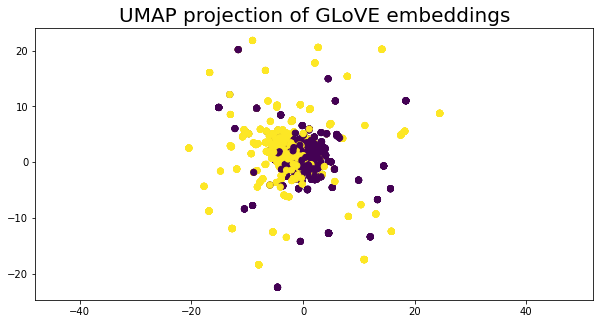

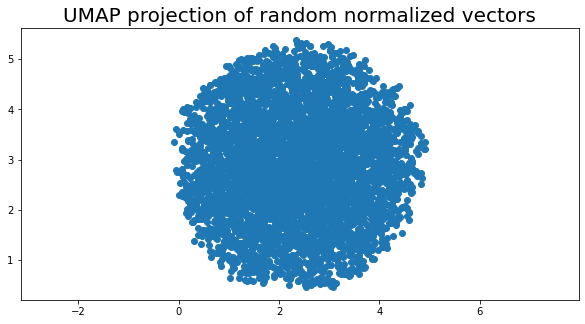

In [26]:
#Q11
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(glove_train)

plt.scatter(embedding[:, 0], embedding[:, 1], c=glove_train_targets)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of GLoVE embeddings', fontsize=20)
plt.show()

#random vectors for comparison
random_vecs = []
for i in range(len(glove_train)):
    vec = np.random.rand(1,300)
    norm_vec = normalize(vec)[0]
    random_vecs.append(norm_vec)

rand_reducer = umap.UMAP()
rand_embedding = reducer.fit_transform(random_vecs)

plt.scatter(rand_embedding[:, 0], rand_embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of random normalized vectors', fontsize=20)
plt.show()